<a href="https://colab.research.google.com/github/KapilKhanal/Books/blob/master/SYSEN_6400_Architecutre_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

architecture_example = [10,12,15,0,4,5,6,7,8]

architecture_example[0] <- number of vehicles with lowest level capacity

architecture_example[1] <- number of vehicles with mid level capacity

architecture_example[2] <- number of vehicles with highest level capacity

architecture_example[3] <- level of charging (0,1,2)

architecture_example[4] <- density of charging (0,1,2)

architecture_example[5] <- Ownership of e-VTOLs (0: own,1: lease)

architecture_example[6] <- Request prioritization

architecture_example[7] <- Selection of e-VTOLs suppliers (0: supplier A, 1: supplier B, 2: Supplier C)

architecture_example[8] <- level of autonomy (0,1,2,3,4)

In [ ]:
import numpy as np

# architecture_example = [0,1,2,3,4,5,6,7]

# architecture_example[0] <- number of vehicles with lowest level capacity

# architecture_example[1] <- number of vehicles with mid level capacity

# architecture_example[2] <- number of vehicles with highest level capacity

# architecture_example[3] <- level of charging

# architecture_example[4] <- density of charging

# architecture_example[5] <- Ownership of e-VTOLs

# architecture_example[6] <- Request prioritization

# architecture_example[7] <- Selection of e-VTOLs suppliers

# architecture_example[8] <- level of autonomy

values = {0: np.arange(5,20,2),
          1: np.arange(5,20,2),
          2: np.arange(5,20,2),
          3: [0,1,2],
          4: np.arange(3,8),
          5: [0,1],
          6: [0,1,2],
          7: [0,1,2],
          8: [0,1,2,3,4]
          }

decisions = list(values.keys())
constraints = {
      7:{ # constraint 4
          5:{1:[0]}, # supplier A does not offer the leasing option
          8:{3:[1],4:[1]}, # supplier B only offers those ranging from level 1 to 3
      }
    }

def generate_architectures(decisions,values,architectures=[{}]):
    if len(decisions) == 0:
      return architectures
    decisions_copy = decisions.copy()
    decision = decisions_copy.pop()
    returning_architectures = []
    for value in values[decision]:
      new_architectures = []
      for architecture in architectures:
        new_architecture = architecture.copy()
        # print(decision,value,new_architecture)
        # Check validity
        valid = True
        if decision in constraints:
          for predecessor in constraints[decision]:
            if predecessor in new_architecture:
              values_selected = new_architecture[predecessor]
              if values_selected in constraints[decision][predecessor]:
                if value in constraints[decision][predecessor][values_selected]:
                  valid = False
                  break
        for successor in constraints:
            if decision in constraints[successor] and successor in new_architecture:
              values_selected = new_architecture[successor]
              if value in constraints[successor][decision]:
                if values_selected in constraints[successor][decision][value]:
                  valid = False
                  break
        if valid:
          new_architecture[decision] = value
          new_architectures.append(new_architecture)
      if len(new_architectures)>0:
        temp_arch = generate_architectures(decisions_copy,values,new_architectures)
        returning_architectures.extend(temp_arch)
    return returning_architectures

all_architectures = generate_architectures(decisions,values)

def encode_architectures_binary(values,architectures,decisions):
  number_digits = 0
  for decision in decisions:
    number_digits+=len(values[decision])
  architecture_arr = np.zeros((len(architectures),number_digits),dtype=np.int8)
  i = 0
  for architecture in architectures:
    digit = 0
    for decision in values:
      architecture_arr[i][digit+architecture[decision]] = 1
      digit+=len(values[decision])
    i+=1
#   np.savetxt("sysen_6400_hw3.csv", architecture_arr, fmt='%s',delimiter=",")

def encode_architectures(values,architectures,decisions):
  architecture_arr = np.zeros((len(architectures),len(decisions)),dtype=np.int8)
  i = 0
  for architecture in architectures:
    digit = 0
    for decision in values:
      architecture_arr[i][digit] = architecture[decision]
      digit+=1
    i+=1
  return architecture_arr
#   np.savetxt("sysen_6400_hw3.csv", architecture_arr, fmt='%s',delimiter=",")

architecture_encodings = encode_architectures(values,all_architectures,decisions)

In [ ]:
len(all_architectures),architecture_encodings.shape

(483840, (483840, 9))

In [ ]:
architecture_encodings[0]

array([5, 5, 5, 0, 3, 0, 0, 0, 0], dtype=int8)

### For each metric, write a function (code) that takes an architecture as an input and
estimate the metric as an output. Test the value function with a few reference
architectures and check that the results make sense. Discuss.

###### Metric 1
Service rate: The percentage of emergency calls that are served

##### Metric 2
The average time taken for response team to arrive at passenger site


In [ ]:
list_arch = generate_architectures(decisions,values,architectures=[{}])
example_arch = list_arch[0]
example_arch

{8: 0, 7: 0, 6: 0, 5: 0, 4: 3, 3: 0, 2: 5, 1: 5, 0: 5}

We adopt a simulation based approach to calculate the metrics as these systems are very operational and depends on the real life environment especially leveraging an agent-based discrete event simulator,

* Design the probability distribution function (pdf) of the set of random variables 𝑋𝑖 on which the metric depends 
* 2. In some cases, the pdf of 𝑌 = 𝑓 𝑋𝑖 can be computed analytically. For example,when f() is a sum, the pdf of Y is given by a convolution, and the convolution ofcertain pdfs is known (e.g. convolution of N independent Gaussians is anotherGaussian with mean=sum of means, variance=sum of variances
* 3. In most cases, analytic computation is infeasible and the pdf of 𝑌 = 𝑓 𝑋𝑖 must beestimated by means of Monte Carlo simulation1. 
* 4. Get a random sample from each of the 𝑋𝑖2. Compute Y for that combination of 𝑋𝑖3. Repeat many times to obtain an empirical probability distribution (essentially a histogram) ofY that approximates the real one

We assume the request takes exponential distibution, density of charging takes uniform distribution, fleet size takes in normal distribution, and capacity of charging takes normal distribution. All other architectural choice affect the parameters of these distribution or sometime they don't affect at all. For example, with a higher level of medical care is unrelated to the service rate but very much related to the some other metric like patient outcome. 

#### We need to map the value from optimizer to each of the levels

### Performance: Service rate and Response time

In [ ]:
import numpy as np

np.random.seed(10)

example_arch = []





def get_charging_time(charging_level):
  if charging_level == 0:
      return np.random.normal(120, 20)
  elif charging_level == 1:
      return np.random.normal(180, 30)
  elif charging_level == 2:
      return np.random.normal(240, 40)
  else:
      return 0

def get_estimated_delay(available_veh,requests):
  #we assume different distribution of delay for each of these parameters
  Tmax = 15 #mins
  delay = min(1,requests/available_veh) * Tmax
  # print(f"available {available_veh} and requests {requests}")
  return delay



def each_available(nf0,nf1,nf2,charging_density,charging_speed,demand):
  avail0 = availability_factor(charging_density,charging_speed,demand) * nf0
  avail1 = availability_factor(charging_density,charging_speed,demand) * nf1
  avail2 = availability_factor(charging_density,charging_speed,demand) * nf2
  return max(1,int(avail0)), max(1,int(avail1)),max(1,int(avail2))

def availability_factor(charging_density,charging_speed,demand):
  max_speed = 1
  max_density = 8
  min_demand = 120
  #print(f"charging speed: {charging_speed} \n charging density:{charging_density}")
  alpha = ((charging_speed * charging_density) / demand) / ((max_speed * max_density)/min_demand)
  #print(f"alpha is {alpha}")
  return alpha

def get_performance_metrics(arch): #optimizer selected value

  density = arch[4]
  charging_speed_enocoder = {0:.5,1:0.75,2:1}
  nf0 = arch[0]
  nf1 = arch[1]
  nf2 = arch[2]
  charging_speed = charging_speed_enocoder[arch[3]]
  arrival_rate_0, arrival_rate_1, arrival_rate_2 = 40,30,20
  request_count_level_0 = np.random.poisson(arrival_rate_0,1) #per day
  
  request_count_level_1 = np.random.poisson(arrival_rate_1,1) #per day
  request_count_level_2 = np.random.poisson(arrival_rate_2,1) #per day
  #print(f"{request_count_level_0} _ {request_count_level_1} _ {request_count_level_2}")
  demand  = request_count_level_0 + request_count_level_1 + request_count_level_2

  #print(f"demand = {demand}")

  available0,available1, available2 = each_available(nf0,nf1,nf2, density, charging_speed,demand)  #fleets_DF[arch['fleets_DF']]
  #print(f"{available0} _ {available1} _ {available2}")


  served_requests_count_2 = min(available2,request_count_level_2)
  response_time_level_2 = get_estimated_delay(available2,served_requests_count_2)
  available2 = available2 - served_requests_count_2
  served_requests_count_1 = min(available1+available2,request_count_level_1)
  response_time_level_1 = get_estimated_delay(available1+available2,served_requests_count_1)
  available_1_2 = available1+available2 - served_requests_count_1 
  served_requests_count_0 = min(available0 + available_1_2,request_count_level_0)
  response_time_level_0 = get_estimated_delay(available0 + available_1_2,served_requests_count_0)
  total_response_time = (response_time_level_2*served_requests_count_2 + response_time_level_1*served_requests_count_1 + response_time_level_0*served_requests_count_0)
  average_response_time = total_response_time/(served_requests_count_0 + served_requests_count_1 + served_requests_count_2)
  service_rate = (served_requests_count_0 + served_requests_count_1 + served_requests_count_2)/(request_count_level_0 + request_count_level_1 + request_count_level_2)
  return [service_rate[0] , average_response_time] 



density = 8 
nf0 = 20
nf1 = 5
nf2 = 5

charging_speed = 1
ownership = 0 #only changes cost
request_prioritization = 1
supplier = 1

arch1 = [nf0,nf1,nf2,charging_speed,density,ownership,request_prioritization,supplier]
get_performance_metrics(arch1)





[0.26804123711340205, 15.0]

In [ ]:

import numpy as np
def compute_NPV(arch, discounted_rate = 0.07, year = 10):
    
    def CER_f(arch):
        
        # The mass of e-VTOLs with different capacity
        mass = np.array([[400, 500, 600],
                        [360, 410, 590],
                        [430, 540, 650]])
        f_1_1 = 20*(mass[arch[7], 0])**2
        
        f_1_2 = 20*(mass[arch[7], 1])**2
        
        f_1_3 = 20*(mass[arch[7], 2])**2
        
        # The mass of medical equipment
        mass_equip = [50, 100, 200]
        f_2_1 = 20*(mass_equip[0])**2
        
        f_2_2 = 20*(mass_equip[1])**2
        
        f_2_3 = 20*(mass_equip[2])**2

        f_3_1 = 500
        
        f_3_2 = 100000
        
        f_4_u = 500000
        
        return f_1_1, f_1_2, f_1_3, f_2_1, f_2_2, f_2_3, f_3_1, f_3_2, f_4_u 
        
    def CER_L(arch):
        coef = [1, 2, 3]
        return coef[arch[3]]
    
    def CER_c(arch):
        
        annual_hours = [1500, 1000, 500]
        # MPH * annual hours * unit cost  
        c_1_1 = 150 * annual_hours[0] * 3
        
        c_1_2 = 150 * annual_hours[1] * 3
        
        c_1_3 = 150 * annual_hours[2] * 3

        c_2_1 = 150000

        c_2_2 = 300000

        lease = np.array([[800000, 900000, 1000000],
                        [780000, 920000, 950000],
                        [820000, 850000, 1100000]])
        
        c_3_1 = lease[arch[7], 0]
        
        c_3_2 = lease[arch[7], 1]
        
        c_3_3 = lease[arch[7], 2]

        maintenance = [3000, 4000, 5000]
        
        c_4_1 = maintenance[0]
        
        c_4_2 = maintenance[0]
        
        c_4_3 = maintenance[0]
        
        return c_1_1, c_1_2, c_1_3, c_2_1, c_2_2, c_3_1, c_3_2, c_3_3, c_4_1, c_4_2, c_4_3
    
    N_1 = arch[0]
    N_2 = arch[1]
    N_3 = arch[2]
    N = arch[0] + arch[1] + arch[2]
    
    M = arch[4]

    I_E = 1 if arch[5] == 1 else 0
    L = CER_L(arch)
    
    # Investment relevant coefficients
    f_1_1, f_1_2, f_1_3, f_2_1, f_2_2, f_2_3, f_3_1, f_3_2, f_4_u = CER_f(arch)

    # Operational cost coefficients
    c_1_1, c_1_2, c_1_3, c_2_1, c_2_2, c_3_1, c_3_2, c_3_3, c_4_1, c_4_2, c_4_3 = CER_c(arch)
    
    # Compute the NPV
    npv = (N_1 * (f_1_1 + f_2_1) + N_2 * (f_1_2 + f_2_2) + N_3 * (f_1_3 + f_2_3)) * I_E + N * f_3_1 + M * f_3_2 + L * M * f_4_u
    
    for i in range(1, year + 1):
        ope_cost = N_1 * (c_1_1 + c_3_1 + c_4_1) + N_2 * (c_1_2 + c_3_2 + c_4_2) + N_3 * (c_1_3 + c_3_3 + c_4_3) + N * c_2_1 + N_3 * c_2_2
        npv += (ope_cost / (1 + discounted_rate)**i)
    return npv
    

### Tradespace
Evaluate architecture on all objectives and plot 

In [293]:
architecture_encodings.shape[0]

483840

In [289]:

performances = [get_performance_metrics(arch) for arch in architecture_encodings]
performances = np.array(performances)

<ipython-input-289-f1d3c6f78595>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  performances = np.array(performances)


In [294]:

npv = np.array([compute_NPV(arch) for arch in architecture_encodings])

In [381]:
architecture_encodings_for_map =[tuple(arch) for arch in architecture_encodings]

#### Need a mapping of architectural encodings and the metrics in a table to retrieve the good architectures.

In [390]:
arch_metrics_table = {arch:np.array([n,ser,res]) for arch,n,ser,res in zip(architecture_encodings_for_map, list(npv),list(performances[:,0]),list(np.concatenate(performances[:,1])))}

In [295]:
print(npv.shape)
print(performances[:,0].shape)
print(performances[:,1].shape)

(483840,)
(483840,)
(483840,)


In [296]:

assert len(npv) == len(performances[:,0]) == len(performances[:,1]), "Input vectors must have the same length."
cond = npv<4.1e8
npv = npv[cond]
performances = performances[cond]
cond1 = performances[:,1]<15 #response <15
performances = performances[cond1]
npv = npv[cond1]

assert len(npv) == len(performances[:,0]) == len(performances[:,1]), "Input vectors must have the same length."

Text(0, 0.5, 'cost')

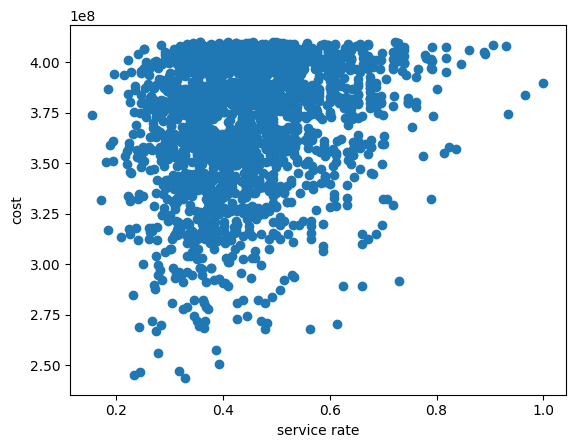

In [297]:
import matplotlib.pyplot as plt
plt.scatter(performances[:,0],npv)
plt.xlabel("service rate")
plt.ylabel("cost")

Text(0, 0.5, 'cost')

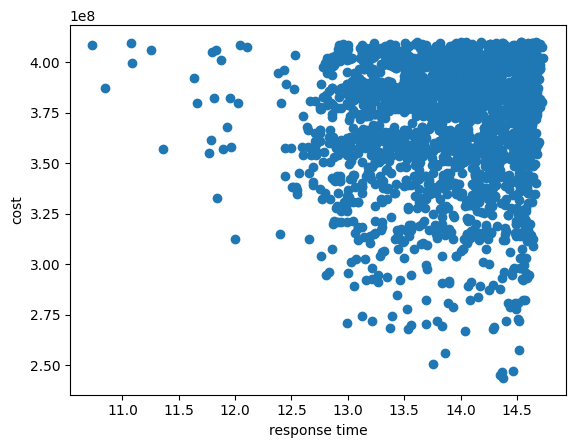

In [298]:
plt.scatter(performances[:,1],npv)
plt.xlabel("response time")
plt.ylabel("cost")

# Generate pareto surface(three objective functions) frontier only from the tradespace

In [299]:
def is_dominated(x, y, max_second=True):
    if x[0] <= y[0] and x[2] <= y[2]:
        if max_second:
            return x[1] >= y[1]
        else:
            return x[1] <= y[1]
    return False
    
def is_pareto(point, points, max_second=True):
    return not any(is_dominated(p, point, max_second) for p in points)
    
def pareto_frontier(X, Y, Z, max_second=True):
    pareto_points = []
    for i in range(len(X)):
        point = [X[i], Y[i], Z[i]]
        if is_pareto(point, pareto_points, max_second):
            pareto_points.append(point)

    return np.array(pareto_points)

# Find Pareto frontier points
pareto_points = pareto_frontier(npv, performances[:,0],performances[:,1]) #(cost, service, response) (min cost, max service, min)

# # Print Pareto frontier points
# print("Pareto Frontier Points:")
# for point in pareto_points:
#     print("({}, {})".format(point[0], point[1],point[2]))



<ipython-input-299-4e9b2f30a9cc>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(pareto_points)


In [300]:
pareto_points = np.array(list(pareto_points))
pareto_points = pareto_points.astype(float)


In [301]:
pareto_points.shape

(105, 3)

In [302]:
npv_rank1 = pareto_points[:,0]
service_rank1 = pareto_points[:,1]
response_rank1 = pareto_points[:,2]

In [303]:
response_rank1

array([14.46745562, 13.49498328, 13.29059829, 13.90909091, 13.73684211,
       13.06547619, 14.50255102, 14.59398496, 14.64285714, 12.4338843 ,
       14.05982906, 13.54054054, 14.22145329, 13.374613  , 13.22410148,
       13.34558824, 14.35406699, 13.94117647, 13.01682692, 14.25438596,
       13.82352941, 14.51970443, 13.875     , 13.19444444, 14.2244898 ,
       13.10810811, 13.        , 13.88198758, 12.63602251, 13.5       ,
       12.80844156, 13.78787879, 12.8671875 , 12.86078098, 13.89795918,
       13.65322056, 13.71794872, 14.2       , 14.01315789, 13.67647059,
       12.94270833, 13.37837838, 12.7540107 , 13.04511278, 13.32298137,
       14.40217391, 13.25252525, 13.54054054, 13.1694664 , 12.99054374,
       13.04347826, 14.35064935, 13.81527348, 13.37037037, 12.76887872,
       12.72077922, 14.00480769, 14.39613527, 13.2       , 13.48739496,
       12.54990926, 13.11576355, 14.04      , 13.44588344, 11.35951557,
       12.51736111, 12.65625   , 14.15625   , 13.15384615, 12.9 

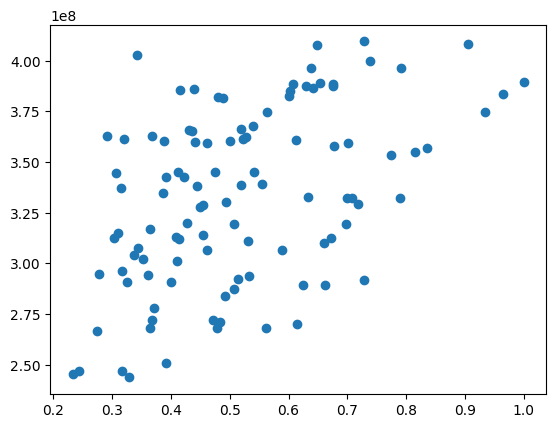

In [304]:
npv1,service1,response1 = zip(*sorted(zip(npv_rank1, service_rank1,response_rank1)))
plt.scatter(service1,npv1)



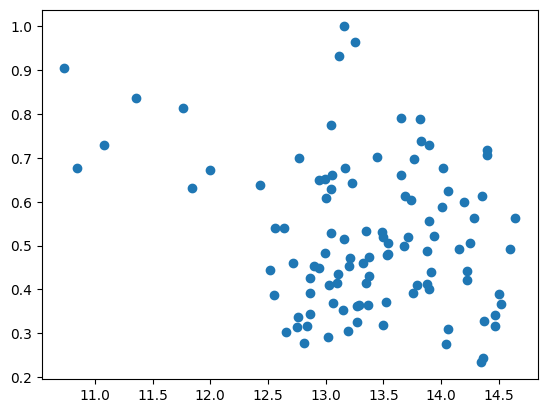

In [305]:
plt.scatter(response1,service1)

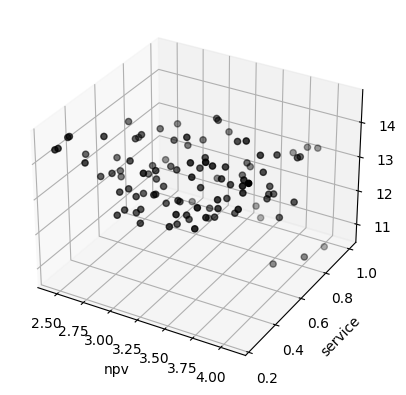

In [306]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the pareto points
x, y, z = pareto_points[:, 0], pareto_points[:, 1], pareto_points[:, 2]
ax.scatter(x, y, z, c='black')

# Create a mesh grid
X, Y = np.meshgrid(np.linspace(x.min(), x.max(), 10), np.linspace(y.min(), y.max(), 10))
Z = np.empty_like(X)
Z.fill(z.min())

# Define the colors based on the max and min values
colors = np.zeros((X.shape[0] - 1, X.shape[1] - 1, 4))
colors[:, :, 0] = 0.75 # Red
colors[:, :, 1] = 0.75 # Green
colors[:, :, 2] = 0.75 # Blue
colors[:, :, 3] = 0.3 # Transparency



# Set the axis labels
ax.set_xlabel('npv')
ax.set_ylabel('service')
ax.set_zlabel('response')

# Show the plot
plt.show()


### Sorting by pareto ranking and let's pick threshold of rank 3.

a)Run and remove the pareto front to get consecutive ranks pareto front

We already have rank1 pareto_points. We remove them and recalculate rank2 pareto points from the remaining points

In [349]:
individuals = np.vstack((npv, performances[:,0], np.concatenate(performances[:,1]))).T

rows_to_remove = np.isin(individuals,pareto_points).all(axis=1)
individuals2 = individuals[~rows_to_remove]

rank2_paretoFronts =  pareto_frontier(individuals2[:,0], individuals2[:,1],individuals2[:,2])

In [351]:
rank2_paretoFronts.shape
x, y, z = rank2_paretoFronts[:, 0], rank2_paretoFronts[:, 1], rank2_paretoFronts[:, 2]
assert len(x) == len(y) ==len(z)

In [242]:
rows_to_remove = np.isin(individuals2,rank2_paretoFronts).all(axis=1)
individuals3 = individuals2[~rows_to_remove]

## Plot all the evaluated objective and also rank1 and rank2 objectives 

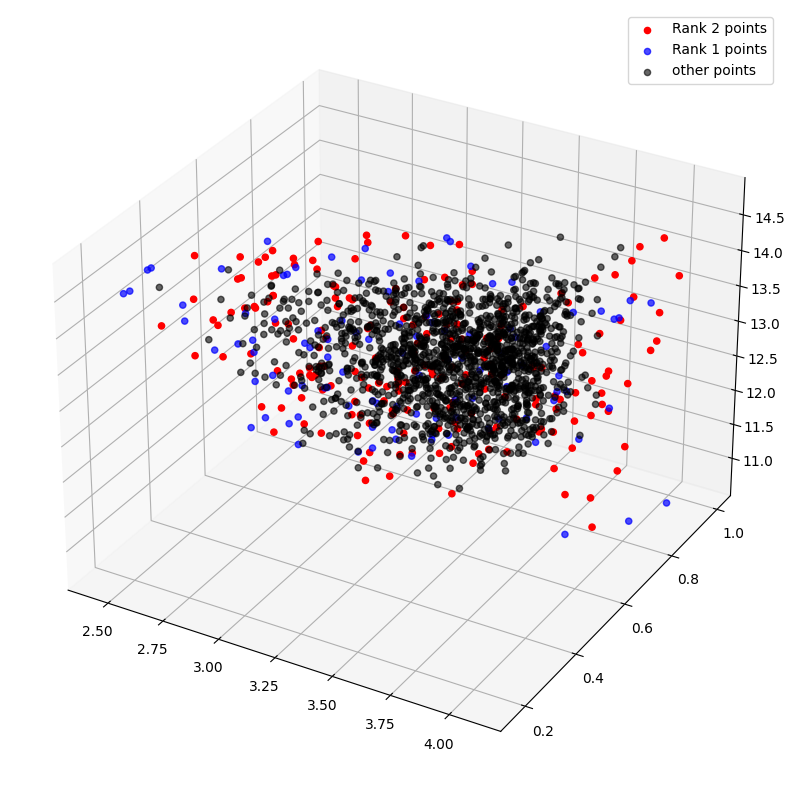

In [354]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection='3d')
x, y, z = rank2_paretoFronts[:, 0], rank2_paretoFronts[:, 1], rank2_paretoFronts[:, 2]
ax.scatter(x.flatten(), y.flatten(), z.flatten(), c = 'red',label="Rank 2 points",alpha = 1)
# Plot the pareto points rank 1
x, y, z = pareto_points[:, 0], pareto_points[:, 1], pareto_points[:, 2]
ax.scatter(x.flatten(), y.flatten(), z.flatten(), c='blue',label="Rank 1 points",alpha = 0.7)

#all other point
# Plot the pareto points rank 1
x, y, z = individuals3[:, 0], individuals3[:, 1], np.concatenate(individuals3[:, 2])
ax.scatter(x.flatten(), y.flatten(), z.flatten(), c='black',alpha = 0.6, label="other points")

# Show the plot
plt.legend()
plt.show()


## Choose few Architectures in the Pareto Front and describe thm and explain why they are good architectures. Does it make sense?


We get the index for all these three points and look at the corresponding index in architectureal_encodings

In [312]:
npv_index,service_index,response_index  = np.where(npv == pareto_points[:,0][3]),np.where(performances[:,0] ==pareto_points[:,1][3]),np.where(performances[:,1] == pareto_points[:,2][3])

npv_index,service_index,response_index

((array([   3, 1662]),),
 (array([   3,  240,  325,  518,  893, 1164, 1223]),),
 (array([  3, 518]),))

We can see that index 3 appears on all of the common index hence that is one of the example

In [317]:
architecture_encodings[3]

array([11,  5,  5,  0,  3,  0,  0,  0,  0], dtype=int8)

Description of the Architecture chosen above. In this pareto front architecture, we have number of vehicles with lowest level capacity == 11 and number of vehicles with mid level capacity == 5

number of vehicles with highest level capacity == 5

level of charging == 0 meaning charging speed is low
density of charging == 3 meaning high number of charging station

Ownership of e-VTOLs == 0 meaning owning the eVTOLs

Request prioritization == 0 meaning that equal prioritization for all patients. 

Selection of e-VTOLs suppliers == 0 which is the supplier A.

level of autonomy == 0 meaning low level of autonomy


## Data Mining for dominant features from pareto front

P--> There are len(pareto_points[:,0]) = 105 rank 1 architectures

In [425]:
architecture_encodings[0]
pareto_points[:,2][104]
# function to return key for any value
def get_arch(val):
    for key, value in arch_metrics_table.items():
      if np.allclose(val, value, rtol=1e-3, atol=1e-3):
        return key

In [421]:
pareto_points[:,2][104]

12.76

## All the good architecures. An architecture is good if it is on the pareto front

In [436]:
values = np.array([np.array([pareto_points[:,0][i],pareto_points[:,1][i], pareto_points[:,2][i]]) for i in range(len(pareto_points))])
P_good_architectures = np.array([list(get_arch([val])) for val in values])

### SUPP(F)

In [439]:
feature_index = [3,4,5,6,7] #total six features of interest

U = len(architecture_encodings)

features_mag  = lambda ind: len(architecture_encodings[architecture_encodings[:,ind]==0])
supp = lambda mag_a,mag_b : mag_a/mag_b
features_supp = {'level_of_charging':supp(features_mag(3),U),'ownership_of_eVTOl':supp(features_mag(4),U),'Request_Prioritization':supp(features_mag(5),U),'selection_eVTOl':supp(features_mag(6),U), 'level_autonomy':supp(features_mag(7),U)}
print(f"The support for features in {features_supp}")


The support for features in {'level_of_charging': 0.3333333333333333, 'ownership_of_eVTOl': 0.0, 'Request_Prioritization': 0.6190476190476191, 'selection_eVTOl': 0.3333333333333333, 'level_autonomy': 0.23809523809523808}


#### SUPP(P)

(105, 9)

### **SUPP**(G $\cap$ F)

In [440]:
good_mag = lambda ind: len(P_good_architectures[P_good_architectures[:,ind]==0])
supp = lambda mag_a,mag_b : mag_a/mag_b
P_features_supp = {'level_of_charging':supp(good_mag(3),U),'ownership_of_eVTOl':supp(good_mag(4),U),'Request_Prioritization':supp(good_mag(5),U),'selection_eVTOl':supp(good_mag(6),U), 'level_autonomy':supp(good_mag(7),U)}
print(f"The support for features in Good  {P_features_supp}")


The support for features in Good  {'level_of_charging': 0.00016947751322751324, 'ownership_of_eVTOl': 0.0, 'Request_Prioritization': 0.00021701388888888888, 'selection_eVTOl': 0.00021701388888888888, 'level_autonomy': 0.00021701388888888888}


### CONF(G$\to$F) = $\frac{|G \cap F|}{|G|}$

### CONF(F$\to$G) = $\frac{|G \cap F|}{|F|}$

In [444]:
conf_G_intersect_f_F = {f:0 for f in P_features_supp.items()}
for feature,val in features_supp.items():
  conf_G_intersect_f_F[feature] = P_features_supp.get(feature)/(val+1000000000) #if division by zero #supplier and leasing have constraints.


print(conf_G_intersect_f_F)

{('level_of_charging', 0.00016947751322751324): 0, ('ownership_of_eVTOl', 0.0): 0, ('Request_Prioritization', 0.00021701388888888888): 0, ('selection_eVTOl', 0.00021701388888888888): 0, ('level_autonomy', 0.00021701388888888888): 0, 'level_of_charging': 1.6947751317102074e-13, 'ownership_of_eVTOl': 0.0, 'Request_Prioritization': 2.1701388875454695e-13, 'selection_eVTOl': 2.1701388881655092e-13, 'level_autonomy': 2.170138888372189e-13}
